### Business Statement : 
OK, so this week, we received a request from our IT department in that we as a company receive a significant amount of spam. So we've been given a collection of emails, both normal and spam, and ***our goal is that we need to process this data and then build a classifier that will classify emails as spam or not spam ***

***So our goal for this week is to build a model that can take any given email and provide a classification.*** So essentially, what we're doing is we're building an email filter. And your task is to go through all of this data, process it, and then build, based on the contents of an email, a model that can predict whether any given email is spam or not spam.


In [274]:
import os 
import glob
import io 
import pandas as pd
import email
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import re 
import numpy as np
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics
import copy
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

import spacy
from spacy import displacy
from contractions import CONTRACTION_MAP

### Common Functions

In [342]:
# this is recursive search of the multiple versions of content types and nested messsages structure of the emails

def search_message_bodies(email_bodies, part):
    type=part.get_content_type()
    if type.startswith('multipart/'):
        if type=='multipart/related':
            # the first part or the one pointed by start 
            start=part.get_param('start', None)
            related_type=part.get_param('type', None)
            for i, subpart in enumerate(part.get_payload()):
                if (not start and i==0) or (start and start==subpart.get('Content-Id')):
                    search_message_bodies(email_bodies, subpart)
                    return
        elif type=='multipart/alternative':
            # all parts are candidates and latest is best
            for subpart in part.get_payload():
                search_message_bodies(email_bodies, subpart)
        elif type in ('multipart/report',  'multipart/signed'):
            # only the first part is candidate
            try:
                subpart=part.get_payload()[0]
            except IndexError:
                return
            else:
                search_message_bodies(email_bodies, subpart)
                return
        elif type=='multipart/signed':
            # cannot handle this
            return

    else:
        if part.get_content_type() == 'text/html':
            stuff = BeautifulSoup(part.get_payload(), 'html.parser')
            data = stuff.find_all('p')
            #data = re.sub(r'\s+', ' ', str(data))
            para = ''
            for i in data:
                para = para + ' ' + i.text
            if para.strip() != '':
                email_bodies.append(para)
        elif part.get_content_type() == 'text/plain':
            email_content = re.sub(r'\s+', ' ', part.get_payload())
            email_bodies.append(email_content)
        return
    
    return


# this function will read each email in given folder and pass content to the search function
def read_email(folder, parent_folder):
    email_bodies = []
    for f in folder:
        with open(parent_folder + f,errors="ignore") as file_email:  
            try:
                file_content = email.message_from_file(file_email)
                search_message_bodies(email_bodies, file_content)
            except:
                print("Oops!", sys.exc_info()[0], "occurred in file", parent_folder + f)
    return email_bodies


# stemmer and tokenizer
def stemmer_tokenizer(email_text, stem=False):
    stop_words = stopwords.words('english')
    stemmer =  SnowballStemmer('english')
    
    # this regular expression will help in eliminating links, unnecessary spaces and special characters
    text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp:\S+|font:\S+|br"
    email_text = re.sub(text_cleaning_re, ' ', str(email_text).lower()).strip()
    tokens = []
    for token in email_text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

def plot_confusion_matrix(y_test, y_hat):
    cm=metrics.confusion_matrix(y_test, y_hat)
    cm/np.sum(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{var1}\n{var2}\n{var3}" for var1,var2,var3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7,5))

    sns.heatmap(cm,
                annot=labels,
                fmt='',
                cmap='coolwarm',
                xticklabels=['Negative or 0','Positive or 1'],
                yticklabels=['Negative or 0','Positive or 1'],
                annot_kws={'size':16})

    plt.title('Confusion Matrix')
    plt.show()

# this function will plot precision and recall curve
def plot_precision_recall(X_test, y_test, model):
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    disp = plot_precision_recall_curve(model, X_test, y_test)

    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
# this function will plot roc curve
def plot_roc_curve(y_test, y_hat):
    rf_roc_auc = metrics.roc_auc_score(y_test,y_hat)
    print('LR ROC:',rf_roc_auc)
    # plot the ROC curve from logistic regression
    logit_roc_auc = metrics.roc_auc_score(y_test, y_hat)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat)
    plt.figure()
    plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# this function will plot data after SMOTE
def plot_class_dist(y, target_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('Target Class Distribution:', target_label);
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('Target Class Counts:', target_label);

def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))


# Expand all contracted text like can't etc. 
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# More text clean up 
def clean_more_email_content(ds):
    ds['Norm_EmailText']=[wd.strip() for wd in ds['Norm_EmailText']]
    ds['Norm_EmailText']=[ re.sub(r'[\r|\n|\r\n|>+|-|\s|*|\d+|:|-|.]',' ',wd) for wd in ds['Norm_EmailText']]
    ds['Norm_EmailText']=[wd for wd in ds['Norm_EmailText'] if wd not in stoplist] 
    ds['Norm_EmailText']=[expand_contractions(wd) for wd in ds['Norm_EmailText']]
    return ds

#### Read all the emails and load content into Dataframe by categotizing into Spam or No spam

In [343]:
os.chdir('../data/')

In [345]:
easy_ham = os.listdir("./easy_ham/")
easy_ham_2 = os.listdir("./easy_ham_2/")
hard_ham = os.listdir("./hard_ham/")
spam = os.listdir("./spam/")
spam_2 = os.listdir("./spam_2/")


##### Out of 9000+ emails there are 17 of them which we could not able to read due to encoding issue. It is very small volume as compared to 9000+ and we are ignoring these 17 emails.

In [346]:
easy_ham_list = []
easy_ham_2_list = []
hard_ham_list = []
spam_list = []
spam_2_list = []


easy_ham_list = read_email(easy_ham, "./easy_ham/")
easy_ham_2_list = read_email(easy_ham_2, "./easy_ham_2/")
hard_ham_list = read_email(hard_ham, "./hard_ham/")
spam_list = read_email(spam, "./spam/")
spam_2_list = read_email(spam_2, "./spam_2/")


easy_ham_df = pd.DataFrame({'EmailText':easy_ham_list,'Classification':'Not Spam'}) 
easy_ham_2_df = pd.DataFrame({'EmailText':easy_ham_2_list,'Classification':'Not Spam'}) 
hard_ham_df = pd.DataFrame({'EmailText':hard_ham_list,'Classification':'Not Spam'}) 
spam_df = pd.DataFrame({'EmailText':spam_list,'Classification':'Spam'}) 
spam_2_df = pd.DataFrame({'EmailText':spam_2_list,'Classification':'Spam'}) 

Oops! <class 'AttributeError'> occurred in file ./spam/00467.5b733c506b7165424a0d4a298e67970f
Oops! <class 'AttributeError'> occurred in file ./spam/0478.16f274ffd3e884a574c9461012cadea6
Oops! <class 'AttributeError'> occurred in file ./spam_2/01214.973b4598b630a989967ff69b19f95d4a


In [347]:
frames = [easy_ham_df, easy_ham_2_df, hard_ham_df, spam_df, spam_2_df]
email_ds = pd.concat(frames)

In [348]:
#result[result["EmailText"].str.replace(' ','') == '[]']
email_ds.shape

(9058, 2)

#### There are no null

In [349]:
print (pd.DataFrame(email_ds.isnull().sum()))

                0
EmailText       0
Classification  0


### Unbalanced sample of Spam and Not Spam

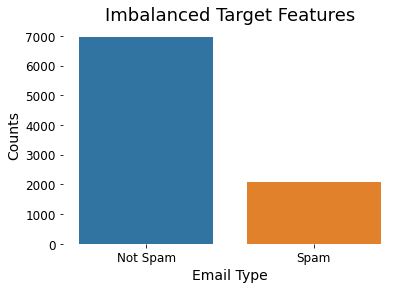

In [102]:
sns.countplot(x="Classification", data = email_ds)
plt.title('Imbalanced Target Features',size=18)
plt.xlabel('Email Type',size=14)
plt.ylabel('Counts',size=14)

plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=12)
plt.yticks(size=12) 
plt.show()

#### Dummy coding Spam or Not to 1 or 0

In [350]:
email_ds_numeric = copy.deepcopy(email_ds)

email_ds_numeric["Classification"] = [1 if i == "Spam" else 0 for i in email_ds["Classification"]]
email_ds_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9058 entries, 0 to 1240
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   EmailText       9058 non-null   object
 1   Classification  9058 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 212.3+ KB


#### Text normalization, using Snowballstemming 

In [351]:
email_ds_numeric["Norm_EmailText"] = email_ds_numeric.EmailText.apply(lambda x: stemmer_tokenizer(x))
email_ds_numeric.head()

,EmailText,Classification,Norm_EmailText
0,"URL: http://www.newsisfree.com/click/-1,838114...",0,url: date: 2002-09-30t03:04:58+01:00 *arts:* f...
1,http://www.guardian.co.uk/Print/0%2c3858%2c44...,0,making mesh move new way give us fast mobile n...
2,"In a message dated 9/24/2002 11:24:58 AM, jam...",0,"message dated 9/24/2002 11:24:58 am, jamesr wr..."
3,"Hiya, I always seem to get errors when I do an...",0,"hiya, always seem get errors ""apt update"", pro..."
4,I don't know how one can expect better and mo...,0,know one expect better secure code community s...


#### Shuffle the dataset to mix the Spam and Not Spam evenly

In [352]:
email_ds_numeric = email_ds_numeric.sample(frac=1).reset_index(drop=True)
email_ds_numeric.head(10)

,EmailText,Classification,Norm_EmailText
0,> > What's an auto-ham? > > Automatically mark...,0,> > what's auto-ham? > > automatically marking...
1,> From: Chris Garrigues <cwg-exmh@DeepEddy.Com...,0,"> from: chris garrigues <cwg-exmh > date: wed,..."
2,"URL: http://www.newsisfree.com/click/-1,863902...",0,url: date: supplied new japanese system allows...
3,"On Tue, Aug 13, 2002 at 09:55:49AM +0100, Ryan...",0,"tue, aug 13, 2002 09:55:49am +0100, ryan, shan..."
4,Ben Mord wrote: > -----Original Message----- >...,0,ben mord wrote: > -----original message----- >...
5,"URL: http://www.newsisfree.com/click/-3,845738...",0,url: date: 2002-10-02t04:58:04+01:00 us reject...
6,"Dear Sir, *·ͨרҵVEͷ(VEñͷܳ),Ҫͺ ʮ4JB1,˹6BT,άµŷ,ʮƤ...",1,"dear sir, *·ͨרҵveͷ(veñͷܳ),ҫͺ ʮ4jb1,˹6bt,άµŷ,ʮƥ..."
7,"Once upon a time, Harig, wrote : > I've found ...",0,"upon time, harig, wrote : > i've found solutio..."
8,URL: http://boingboing.net/#85485985 Date: Not...,0,url: date: supplied horror writers america hos...
9,This article from NYTimes.com has been sent to...,0,"article nytimes.com sent khare axelrod, eh? ""t..."


In [353]:
email_ds_numeric["Classification"].value_counts()

0    6969
1    2089
Name: Classification, dtype: int64

In [69]:
#email_ds_numeric['Norm_EmailText'].apply(lambda x: x.replace('>',''))

### SPAM text visualization:

In [47]:
spam_text = email_ds_numeric.loc[email_ds_numeric['Classification']==1,'Norm_EmailText']
spam_text = ' '.join(spam_text)

In [48]:
spam_tex_tok = nltk.word_tokenize(spam_text)

In [51]:
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english")) 

In [53]:
spam_tok_no_sword = [wd for wd in spam_tex_tok if wd not in stoplist]
spam_tok_no_sword = [wd for wd in spam_tok_no_sword if wd not in stoplist if wd.isalpha()]

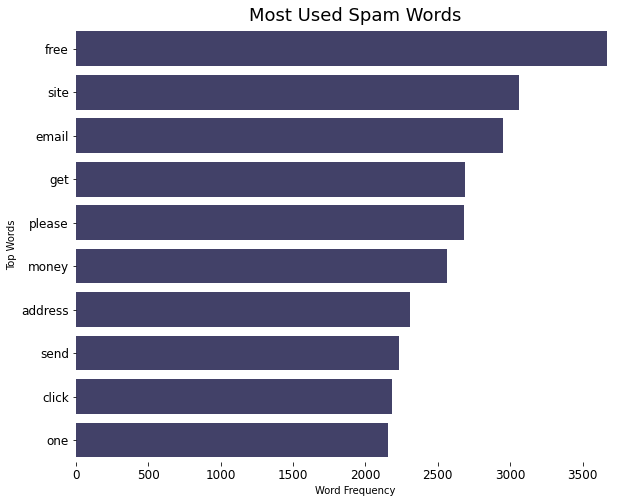

In [60]:
#spam_tok_no_sword
fdist = nltk.FreqDist(wd for wd in spam_tok_no_sword)
x=[]
y=[]
for word,count in fdist.most_common(10):
    x.append(word)
    y.append(count)
    
plt.figure(figsize=(10,8))
sns.barplot(x=y,y=x,color='#3C3B6E')  
plt.title('Most Used Spam Words',size=18)
plt.xlabel('Word Frequency')
plt.ylabel('Top Words')
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=12)
plt.yticks(size=12) 
plt.show()

### HAM text visualization:


In [97]:
ham_text = email_ds_numeric.loc[email_ds_numeric['Classification']==0,'Norm_EmailText']
ham_text = ' '.join(ham_text)

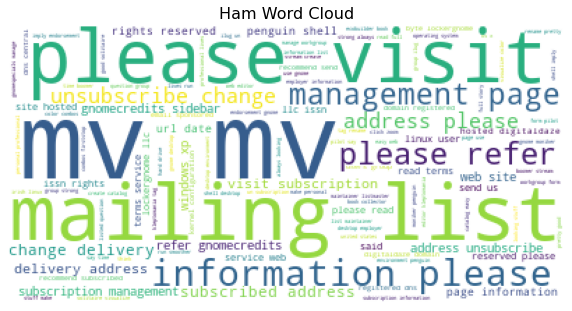

In [334]:
ham_tex_tok = nltk.word_tokenize(ham_text)
ham_tok_no_sword = [wd for wd in ham_tex_tok if wd not in stoplist]
ham_tok_no_sword = [wd for wd in ham_tok_no_sword if wd not in stoplist if wd.isalpha()]
# #spam_tok_no_sword
# fdist = nltk.FreqDist(wd for wd in ham_tok_no_sword)
# x_ham=[]
# y_ham=[]
# for word,count in fdist.most_common(10):
#     x_ham.append(word)
#     y_ham.append(count) 
    
# plt.figure(figsize=(10,8))
# sns.barplot(x=y_ham,y=x_ham,color='#145A32')  
# plt.title('Most Used Not Spam Words',size=18)
# plt.xlabel('Word Frequency')
# plt.ylabel('Top Words')
# plt.rcParams['axes.spines.right']=False # remove the plot border
# plt.rcParams['axes.spines.left']=False # remove the plot border
# plt.rcParams['axes.spines.top']=False # remove the plot border
# plt.rcParams['axes.spines.bottom']=False # remove the plot border
# plt.xticks(size=12)
# plt.yticks(size=12) 
# plt.show()


ham_sent = ' '.join(ham_tok_no_sword)
wordCld = WordCloud(background_color='white').generate(ham_sent)
plt.figure(figsize=(10,9))
plt.imshow(wordCld)
plt.axis('off')
plt.title('Ham Word Cloud',size=16)
plt.show()

#### Spam Tag Cloud

Text(0.5, 1.0, 'Spam Word Cloud')

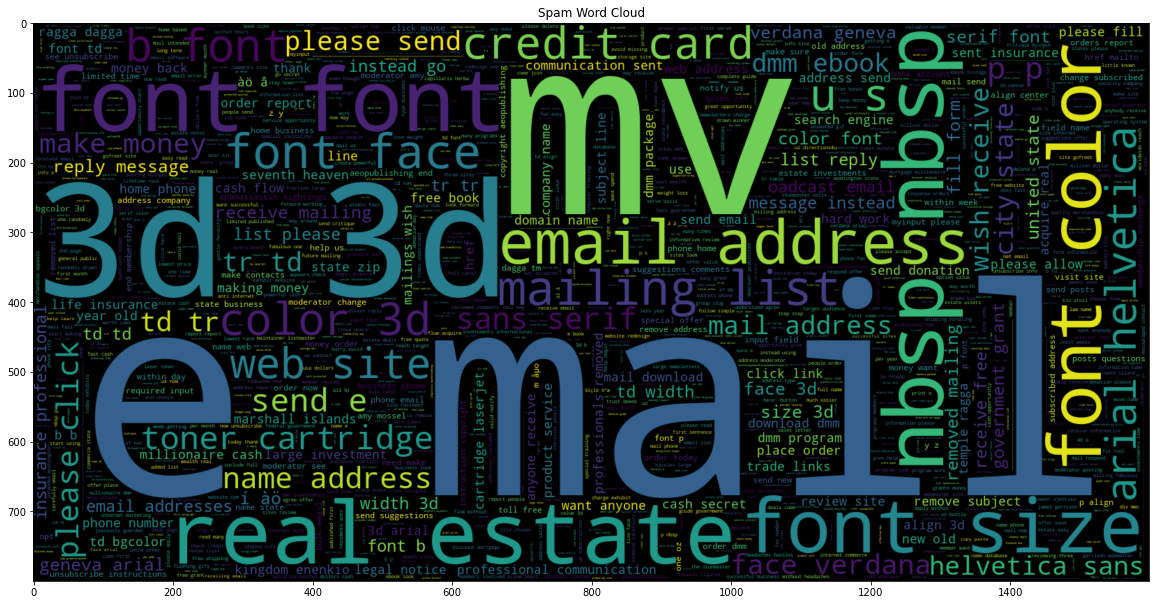

In [118]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(email_ds_numeric[email_ds_numeric.Classification == 1].Norm_EmailText))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

#### Not spam Tag cloud

Text(0.5, 1.0, 'Not Spam Word Cloud')

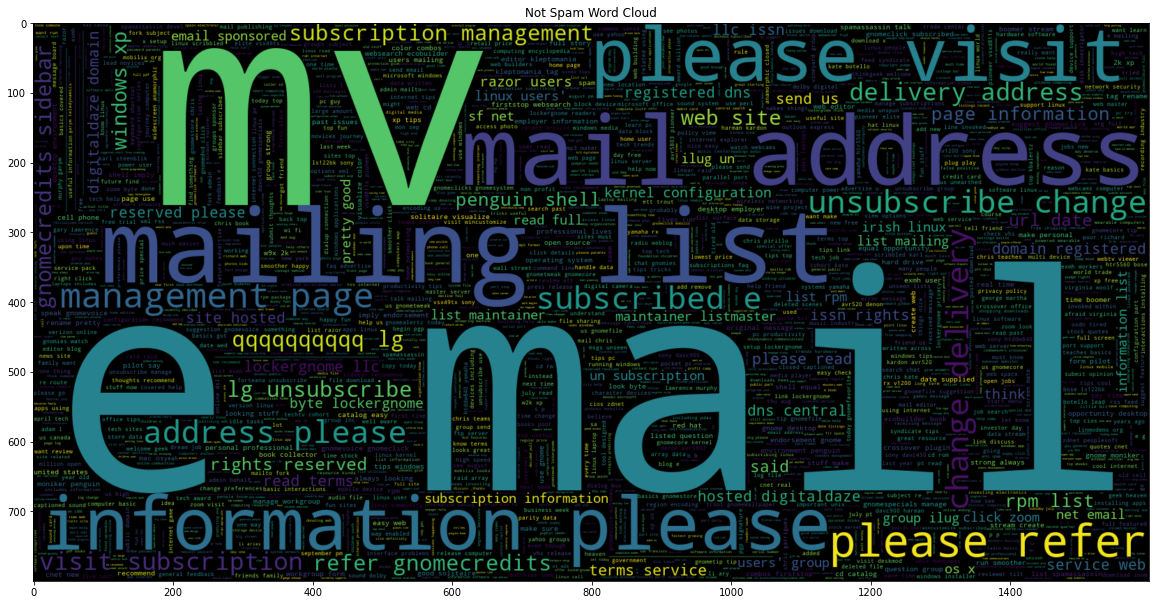

In [119]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(email_ds_numeric[email_ds_numeric.Classification == 0].Norm_EmailText))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Not Spam Word Cloud")

#### More Text clean up

In [354]:
email_ds_numeric = clean_more_email_content(email_ds_numeric) 

#### Creating the Bag of Words model

In [355]:
# Creating the Bag of Words model
cv = CountVectorizer()
X = cv.fit_transform(email_ds_numeric['Norm_EmailText'].values).toarray()
y = email_ds_numeric.iloc[:, 1].values

In [356]:
X.shape

(9058, 63872)

In [357]:
y.shape

(9058,)

#### Using an 80–20 ratio to split the data frame into train-test sets. The train_test_split function of the sklearn.model_selection module is used.

In [358]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1234)

In [359]:
X_train.shape 

(7246, 63872)

In [360]:
X_test.shape

(1812, 63872)

### 1. Naive Bayes classification model with unbalanced data

In [361]:
# Fitting Naive Bayes classifier to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
classifier.fit(X_train , y_train)

MultinomialNB()

In [362]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [363]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

[[1388   11]
 [  19  394]]


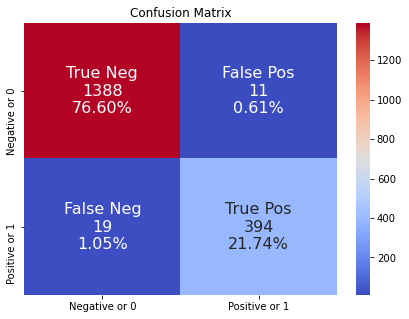

In [364]:
# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(y_test, y_pred)

In [365]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1399
           1       0.97      0.95      0.96       413

    accuracy                           0.98      1812
   macro avg       0.98      0.97      0.98      1812
weighted avg       0.98      0.98      0.98      1812



In [366]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [367]:
print(accuracies.mean())
print(accuracies.std())

0.9777799580872548
0.006404570744561412


In [369]:
accuracies

array([0.98068966, 0.97241379, 0.98206897, 0.97793103, 0.97931034,
       0.98068966, 0.96961326, 0.99033149, 0.97790055, 0.96685083])

LR ROC: 0.9730661991356676


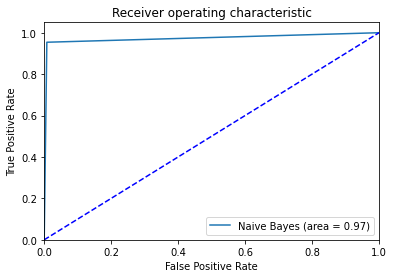

In [370]:
plot_roc_curve(y_test, y_pred)
plt.rcParams['axes.spines.right']=True
plt.rcParams['axes.spines.left']=True
plt.rcParams['axes.spines.top']=True
plt.rcParams['axes.spines.bottom']=True

<br/>
<br/>

### 2. Naive Bayes classification model with balanced data using ComplementNB

In [371]:
# Fitting Naive Bayes classifier to the Training set
classifier_cnb =  ComplementNB(alpha=1, norm=False)
classifier_cnb.fit(X_train , y_train)

ComplementNB(alpha=1)

In [372]:
# Predicting the Test set results
y_pred_cnb = classifier_cnb.predict(X_test)

In [373]:
y_pred_cnb

array([0, 0, 0, ..., 0, 0, 0])

[[1384   15]
 [  17  396]]


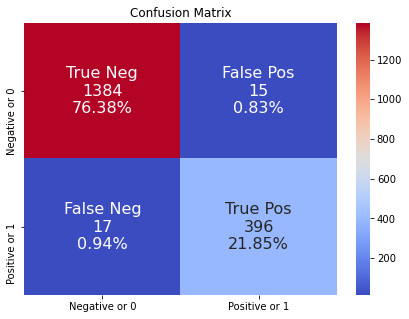

In [378]:
# Making the Confusion Matrix
cm_cnb = metrics.confusion_matrix(y_test, y_pred_cnb) 
print(cm_cnb)
plot_confusion_matrix(y_test, y_pred_cnb)

In [379]:
print(metrics.classification_report(y_test,y_pred_cnb))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1399
           1       0.96      0.96      0.96       413

    accuracy                           0.98      1812
   macro avg       0.98      0.97      0.97      1812
weighted avg       0.98      0.98      0.98      1812



In [376]:
# Applying k-Fold Cross Validation
accuracies_cbn = cross_val_score(estimator = classifier_cnb, X = X_train, y = y_train, cv = 10)

In [380]:
print(accuracies_cbn.mean())
print(accuracies_cbn.std())

0.9781945132406171
0.005982381110791828


LR ROC: 0.9740579140756023


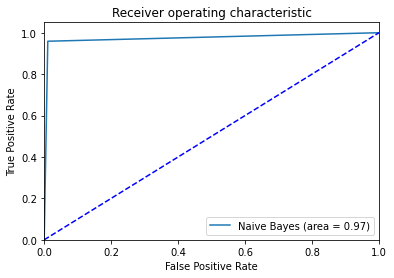

In [381]:
plot_roc_curve(y_test, y_pred_cnb)

In [382]:
email_ds_num_no_dup = copy.deepcopy(email_ds_numeric)

#### There are some duplicates in the dataset.

In [383]:
email_ds_num_no_dup.drop_duplicates(inplace = True)
email_ds_num_no_dup.shape

(5644, 3)

#### Creating the Bag of Words model

In [384]:
# Creating the Bag of Words model
cv = CountVectorizer()
X = cv.fit_transform(email_ds_num_no_dup['Norm_EmailText'].values).toarray()
y = email_ds_num_no_dup.iloc[:, 1].values

In [385]:
X.shape

(5644, 63872)

#### Using an 80–20 ratio to split the data frame into train-test sets. The train_test_split function of the sklearn.model_selection module is used.

In [386]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1234)

### 3. Naive Bayes classification model with balanced data after dropping duplicate records

In [398]:
# Fitting Naive Bayes classifier to the Training set
classifier = ComplementNB(alpha=1.0, norm=False)
classifier.fit(X_train , y_train)

ComplementNB()

In [399]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [400]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

[[837  17]
 [ 13 262]]


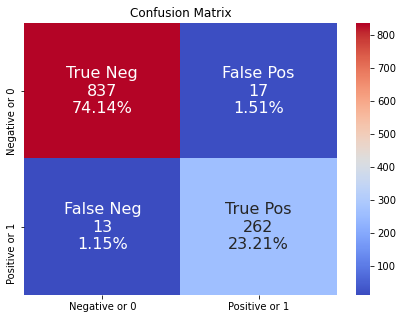

In [401]:
# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred) 
print(cm)
plot_confusion_matrix(y_test, y_pred)

In [402]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       854
           1       0.94      0.95      0.95       275

    accuracy                           0.97      1129
   macro avg       0.96      0.97      0.96      1129
weighted avg       0.97      0.97      0.97      1129



In [403]:
#this function computes subset accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred,normalize=False)

1099

In [404]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [405]:
print(accuracies.mean())
print(accuracies.std())

0.9623501363734475
0.007782924458001852


In [406]:
accuracies

array([0.95575221, 0.97345133, 0.96902655, 0.94911504, 0.95353982,
       0.96008869, 0.96674058, 0.9578714 , 0.97117517, 0.96674058])

In [407]:
print('AUC ROC Score On No Dubpliate Text = ',metrics.roc_auc_score(y_test, y_pred)) 

AUC ROC Score On No Dubpliate Text =  0.9664104747711304


LR ROC: 0.9664104747711304


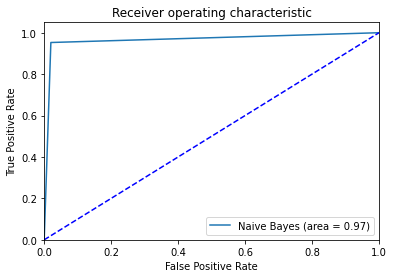

In [408]:
plot_roc_curve(y_test, y_pred)

<br/>
<br/>